In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

In [3]:
def Get_Seoul_Weather_data():
    """
    Load and standardize daily Seoul weather data from multiple CSVs.
    - Merges all 'seoul *.csv' files
    - Selects and renames key columns to consistent names
    - Parses dates, removes duplicates, sorts, and sets Date as index
    - Converts temperature fields to °C for dates before 2022-01-01
    - Returns a clean, analysis-ready DataFrame indexed by Date
    """

    # Gather and concatenate all source CSV files
    csvs = glob.glob("Seoul_Weather_dataset/seoul *.csv")
    dfs = [pd.read_csv(f) for f in csvs]
    data = pd.concat(dfs, ignore_index=True)

    # Keep only the columns we need
    data = data[[
        "datetime", "tempmax", "tempmin", "temp", "dew", "humidity", "precip",
        "windspeed", "winddir", "sealevelpressure", "cloudcover", "visibility",
        "sunrise", "sunset", "moonphase", "description"
    ]]
    
    # Rename columns to consistent, readable names
    data = data.rename(columns={
        "datetime": "Date",
        "tempmax": "TempMax",
        "tempmin": "TempMin",
        "temp": "Temp",
        "dew": "Dew",
        "humidity": "Humi",
        "precip": "Prec",
        "windspeed": "WindSpe",
        "winddir": "WindDir",
        "sealevelpressure": "Pres",
        "cloudcover": "CloudCover",
        "visibility": "Visibility",
        "sunrise": "Sunrise",
        "sunset": "Sunset",
        "moonphase": "MoonPhase",
        "description": "Description"
    })
    
    # Parse dates, drop duplicate days, sort, and set index
    data["Date"] = pd.to_datetime(data["Date"])
    data = data.drop_duplicates(subset="Date")
    data = data.sort_values(by="Date").reset_index(drop=True)
    data = data.set_index("Date")
    
    # Convert temperature units (°F -> °C) for pre-2022 data
    temp_cols = ["TempMax", "TempMin", "Temp", "Dew"]
    mask = data.index < pd.Timestamp("2022-01-01")
    for col in temp_cols:
        if col in data.columns:
            data.loc[mask, col] = (data.loc[mask, col] - 32) * 5/9

    return data

In [6]:
Seoul_Weather_data = Get_Seoul_Weather_data()
Seoul_Weather_data.head()

,TempMax,TempMin,Temp,Dew,Humi,Prec,WindSpe,WindDir,Pres,CloudCover,Visibility,Sunrise,Sunset,MoonPhase,Description
Date,,,,,,,,,,,,,,,
1994-01-01,1.777778,-8.666667,-3.166667,-9.166667,65.9,0.000,5.5,115.4,1025.4,63.0,6.6,1994-01-01T07:46:54,1994-01-01T17:23:56,0.61,Partly cloudy throughout the day.
1994-01-02,6.111111,-0.277778,2.333333,-2.277778,72.1,0.000,9.1,181.7,1022.2,88.8,6.9,1994-01-02T07:47:03,1994-01-02T17:24:44,0.65,Partly cloudy throughout the day.
1994-01-03,8.833333,-0.611111,3.333333,-2.611111,68.1,0.000,12.8,289.5,1020.0,57.4,5.3,1994-01-03T07:47:11,1994-01-03T17:25:33,0.68,Partly cloudy throughout the day.
1994-01-04,3.777778,-5.500000,-1.055556,-10.222222,51.2,0.000,11.7,301.9,1025.1,16.3,7.3,1994-01-04T07:47:16,1994-01-04T17:26:23,0.72,Clear conditions throughout the day.
1994-01-05,4.444444,-4.444444,0.611111,-5.722222,63.9,0.011,6.8,134.1,1023.9,90.4,6.2,1994-01-05T07:47:19,1994-01-05T17:27:14,0.75,Cloudy skies throughout the day with late afte...


In [4]:
def Get_Seoul_PM25_data():
    """
    Load and process Seoul air pollution data (PM2.5).
    - Reads measurement summary CSV
    - Filters for station code 101
    - Converts measurement timestamps to daily resolution
    - Computes daily average PM2.5 concentration
    - Returns a pandas Series indexed by Date
    """

    data = pd.read_csv("Seoul_Air_Pollution_dataset/Measurement_summary.csv")
    data = data.rename(columns={"Measurement date": "Date"})
    data["Date"] = pd.to_datetime(data["Date"]).dt.floor("D")  # to remove time term
    
    # Filter for station 101 (selected measurement site)
    data = data[data["Station code"] == 101]
    
    # Compute daily mean PM2.5 concentration
    PM25 = data.groupby("Date")["PM2.5"].mean()

    return PM25

In [5]:
Seoul_PM25_data = Get_Seoul_PM25_data()
Seoul_PM25_data.head()

Date
2017-01-01    67.291667
2017-01-02    87.166667
2017-01-03    51.833333
2017-01-04    34.916667
2017-01-05    21.958333
Name: PM2.5, dtype: float64

In [6]:
def Get_Merged_Seoul_data():
    """
    Merge daily Seoul weather and air pollution (PM2.5) data.
    - Loads processed weather and PM2.5 datasets
    - Merges them by matching Date index
    - Keeps all weather records (left join)
    - Returns a combined DataFrame indexed by Date
    """

    weather = Get_Seoul_Weather_data()
    PM25 = Get_Seoul_PM25_data()
    merged = weather.merge(PM25, left_index=True, right_index=True, how="left")

    return merged

In [7]:
Seoul_data = Get_Merged_Seoul_data()
Seoul_data.loc[
    ((Seoul_data.index >= "2016-12-31") & (Seoul_data.index <= "2017-01-01")) |
    ((Seoul_data.index >= "2019-12-31") & (Seoul_data.index <= "2020-01-01"))
]

,TempMax,TempMin,Temp,Dew,Humi,Prec,WindSpe,WindDir,Pres,CloudCover,Visibility,Sunrise,Sunset,MoonPhase,Description,PM2.5
Date,,,,,,,,,,,,,,,,
2016-12-31,5.888889,-5.722222,0.277778,-5.722222,64.6,0.000,5.5,117.7,1029.8,59.7,5.2,2016-12-31T07:46:44,2016-12-31T17:23:27,0.06,Partly cloudy throughout the day.,NaN
2017-01-01,8.055556,-3.611111,2.722222,-2.000000,72.0,0.000,5.8,131.6,1028.1,70.9,2.6,2017-01-01T07:46:53,2017-01-01T17:24:13,0.10,Partly cloudy throughout the day.,67.291667
2019-12-31,-5.000000,-10.111111,-7.166667,-17.000000,46.3,0.008,13.3,309.3,1034.4,14.2,7.1,2019-12-31T07:46:35,2019-12-31T17:22:54,0.16,Clear conditions throughout the day with late ...,18.791667
2020-01-01,1.000000,-6.000000,-2.222222,-7.833333,65.9,0.003,3.6,55.9,1032.3,96.1,6.5,2020-01-01T07:46:47,2020-01-01T17:23:40,0.19,Cloudy skies throughout the day with afternoon...,NaN


In [8]:
def Get_Beijing_data():
    """
    Load and process Beijing weather and PM2.5 dataset.
    - Reads raw data and constructs a daily-level DataFrame
    - Converts wind direction strings to numeric degrees
    - Calculates wind components (u, v) and reconstructs daily average wind direction/speed
    - Aggregates daily mean or sum for key variables
    - Renames columns for consistency with Seoul dataset
    - Returns a cleaned daily DataFrame indexed by Date
    """

    data = pd.read_csv("Beijing_Weather_PM_dataset/BeijingPM20100101_20151231.csv")
    data["Date"] = pd.to_datetime(data[["year", "month", "day"]])

    # Map wind direction strings to corresponding degree values
    dir_deg_map = {
        "N": 0,
        "NE": 45,
        "E": 90,
        "SE": 135,
        "S": 180,
        "SW": 225,
        "W": 270,
        "NW": 315
    }
    data["wind_deg"] = data["cbwd"].map(dir_deg_map)
    data.loc[data["cbwd"] == "cv", "wind_deg"] = np.nan  # handle calm or variable winds

    # Convert wind direction to vector components (u, v)
    rad = np.deg2rad(data["wind_deg"])
    data["u"] = data["Iws"] * np.cos(rad)
    data["v"] = data["Iws"] * np.sin(rad)

    # Aggregate data to daily resolution
    daily_data = data.groupby("Date").agg({
        "TEMP": "mean",
        "DEWP": "mean",
        "HUMI": "mean",
        "precipitation": "sum",
        "Iws": "mean",
        "u": "mean",
        "v": "mean",
        "PRES": "mean",
        "PM_US Post": "mean"
    })

    # Compute daily mean wind direction and speed from u, v components
    daily_data["WindDir"] = (np.degrees(np.arctan2(daily_data["v"], daily_data["u"])) + 360) % 360
    daily_data["WindSpe"] = np.hypot(daily_data["u"], daily_data["v"])

    # Rename columns for consistency with Seoul dataset
    daily_data = daily_data.rename(columns={
        "TEMP": "Temp",
        "DEWP": "Dew",
        "HUMI": "Humi",
        "precipitation": "Prec",
        "PRES": "Pres",
        "PM_US Post": "PM2.5"
    }).drop(columns=["u", "v"])

    return daily_data

In [9]:
Beijing_data = Get_Beijing_data()
Beijing_data.head()

,Temp,Dew,Humi,Prec,Iws,Pres,PM2.5,WindDir,WindSpe
Date,,,,,,,,,
2010-01-01,-6.750000,-18.750000,38.458333,0.0,14.458333,1017.083333,129.000000,315.299406,16.311651
2010-01-02,-5.125000,-8.500000,77.937500,0.0,24.860000,1024.750000,144.333333,135.000000,24.860000
2010-01-03,-8.541667,-10.125000,87.916667,11.2,70.937917,1022.791667,78.375000,135.000000,73.934545
2010-01-04,-11.500000,-20.875000,46.208333,0.0,111.160833,1029.291667,29.291667,315.000000,111.160833
2010-01-05,-14.458333,-24.583333,42.041667,0.0,56.920000,1033.625000,43.541667,325.566729,50.887294


In [10]:
def Add_SolarTerm(df):
    """
    Add a 'SolarTerm' column to a DataFrame indexed by date.
    - Defines 24 traditional Korean solar terms and their approximate dates
    - Computes each term’s yearly boundaries
    - Assigns each date in the DataFrame to its corresponding solar term
    - Returns a new DataFrame with an added 'SolarTerm' column
    """

    solar_terms = [
        "입춘", "우수", "경칩", "춘분", "청명", "곡우", "입하", "소만", "망종",
        "하지", "소서", "대서", "입추", "처서", "백로", "추분", "한로", "상강",
        "입동", "소설", "대설", "동지", "소한", "대한"
    ]

    solar_term_dates = [
        "02-04", "02-19", "03-06", "03-21", "04-05", "04-20", "05-06", "05-21", "06-06",
        "06-21", "07-07", "07-22", "08-07", "08-23", "09-07", "09-23", "10-08", "10-23",
        "11-07", "11-22", "12-07", "12-22", "01-06", "01-20"
    ]

    dates = df.index
    years = sorted(dates.year.unique())

    term_boundaries = []
    for year in years:
        for md in solar_term_dates:
            term_boundaries.append(pd.Timestamp(f"{year}-{md}"))
    term_boundaries = sorted(term_boundaries)

    def find_term(date):
        """
        Determine the corresponding solar term for a given date.
        - Builds a list of solar term boundary timestamps for the current and previous year
        - Compares the date against each term boundary
        - Returns the solar term name the date falls into
        """

        year = date.year
        year_terms = [pd.Timestamp(f"{year}-{md}") for md in solar_term_dates]
        prev_year_terms = [pd.Timestamp(f"{year-1}-{md}") for md in solar_term_dates]
        year_terms = sorted(prev_year_terms[-2:] + year_terms)

        for i in range(len(year_terms) - 1):
            if year_terms[i] <= date < year_terms[i + 1]:
                return solar_terms[i % 24]

        return "대한"

    df = df.copy()
    df["SolarTerm"] = [find_term(d) for d in dates]

    return df

In [11]:
seoul_df = Get_Merged_Seoul_data()
seoul_df = Add_SolarTerm(seoul_df)
seoul_df.head(10)

,TempMax,TempMin,Temp,Dew,Humi,Prec,WindSpe,WindDir,Pres,CloudCover,Visibility,Sunrise,Sunset,MoonPhase,Description,PM2.5,SolarTerm
Date,,,,,,,,,,,,,,,,,
1994-01-01,1.777778,-8.666667,-3.166667,-9.166667,65.9,0.000,5.5,115.4,1025.4,63.0,6.6,1994-01-01T07:46:54,1994-01-01T17:23:56,0.61,Partly cloudy throughout the day.,NaN,우수
1994-01-02,6.111111,-0.277778,2.333333,-2.277778,72.1,0.000,9.1,181.7,1022.2,88.8,6.9,1994-01-02T07:47:03,1994-01-02T17:24:44,0.65,Partly cloudy throughout the day.,NaN,우수
1994-01-03,8.833333,-0.611111,3.333333,-2.611111,68.1,0.000,12.8,289.5,1020.0,57.4,5.3,1994-01-03T07:47:11,1994-01-03T17:25:33,0.68,Partly cloudy throughout the day.,NaN,우수
1994-01-04,3.777778,-5.500000,-1.055556,-10.222222,51.2,0.000,11.7,301.9,1025.1,16.3,7.3,1994-01-04T07:47:16,1994-01-04T17:26:23,0.72,Clear conditions throughout the day.,NaN,우수
1994-01-05,4.444444,-4.444444,0.611111,-5.722222,63.9,0.011,6.8,134.1,1023.9,90.4,6.2,1994-01-05T07:47:19,1994-01-05T17:27:14,0.75,Cloudy skies throughout the day with late afte...,NaN,우수
1994-01-06,5.944444,-3.277778,1.944444,-3.888889,66.7,0.095,11.8,290.2,1021.9,57.2,5.1,1994-01-06T07:47:21,1994-01-06T17:28:07,0.79,Partly cloudy throughout the day with morning ...,NaN,경칩
1994-01-07,2.777778,-7.944444,-2.500000,-11.500000,52.1,0.000,9.1,229.3,1028.6,30.1,7.4,1994-01-07T07:47:20,1994-01-07T17:29:01,0.83,Partly cloudy throughout the day.,NaN,경칩
1994-01-08,6.833333,-5.444444,1.222222,-4.277778,67.7,0.000,14.7,189.7,1020.3,46.6,7.6,1994-01-08T07:47:17,1994-01-08T17:29:56,0.86,Partly cloudy throughout the day.,NaN,경칩
1994-01-09,9.333333,0.888889,5.000000,1.277778,77.4,0.000,8.9,206.0,1018.6,74.3,3.7,1994-01-09T07:47:12,1994-01-09T17:30:52,0.90,Partly cloudy throughout the day.,NaN,경칩


In [12]:
beijing_df = Get_Beijing_data()
beijing_df = Add_SolarTerm(beijing_df)
beijing_df.head(10)

,Temp,Dew,Humi,Prec,Iws,Pres,PM2.5,WindDir,WindSpe,SolarTerm
Date,,,,,,,,,,
2010-01-01,-6.750000,-18.750000,38.458333,0.0,14.458333,1017.083333,129.000000,315.299406,16.311651,우수
2010-01-02,-5.125000,-8.500000,77.937500,0.0,24.860000,1024.750000,144.333333,135.000000,24.860000,우수
2010-01-03,-8.541667,-10.125000,87.916667,11.2,70.937917,1022.791667,78.375000,135.000000,73.934545,우수
2010-01-04,-11.500000,-20.875000,46.208333,0.0,111.160833,1029.291667,29.291667,315.000000,111.160833,우수
2010-01-05,-14.458333,-24.583333,42.041667,0.0,56.920000,1033.625000,43.541667,325.566729,50.887294,우수
2010-01-06,-12.541667,-23.708333,39.208333,0.0,18.511667,1033.750000,59.375000,35.178430,17.400480,경칩
2010-01-07,-12.500000,-21.250000,49.000000,0.0,10.170000,1034.083333,72.458333,316.887070,12.147114,경칩
2010-01-08,-11.708333,-17.125000,64.541667,0.0,1.972917,1028.000000,174.333333,333.285908,0.567315,경칩
2010-01-09,-9.125000,-16.333333,57.250000,0.0,13.298750,1029.041667,84.750000,15.223908,11.059706,경칩


Date
1994    Axes(0.125,0.11;0.775x0.77)
1995    Axes(0.125,0.11;0.775x0.77)
1996    Axes(0.125,0.11;0.775x0.77)
1997    Axes(0.125,0.11;0.775x0.77)
1998    Axes(0.125,0.11;0.775x0.77)
1999    Axes(0.125,0.11;0.775x0.77)
2000    Axes(0.125,0.11;0.775x0.77)
2001    Axes(0.125,0.11;0.775x0.77)
2002    Axes(0.125,0.11;0.775x0.77)
2003    Axes(0.125,0.11;0.775x0.77)
2004    Axes(0.125,0.11;0.775x0.77)
2005    Axes(0.125,0.11;0.775x0.77)
2006    Axes(0.125,0.11;0.775x0.77)
2007    Axes(0.125,0.11;0.775x0.77)
2008    Axes(0.125,0.11;0.775x0.77)
2009    Axes(0.125,0.11;0.775x0.77)
2010    Axes(0.125,0.11;0.775x0.77)
2011    Axes(0.125,0.11;0.775x0.77)
2012    Axes(0.125,0.11;0.775x0.77)
2013    Axes(0.125,0.11;0.775x0.77)
2014    Axes(0.125,0.11;0.775x0.77)
2015    Axes(0.125,0.11;0.775x0.77)
2016    Axes(0.125,0.11;0.775x0.77)
2017    Axes(0.125,0.11;0.775x0.77)
2018    Axes(0.125,0.11;0.775x0.77)
2019    Axes(0.125,0.11;0.775x0.77)
2020    Axes(0.125,0.11;0.775x0.77)
2021    Axes(0.125,0.11

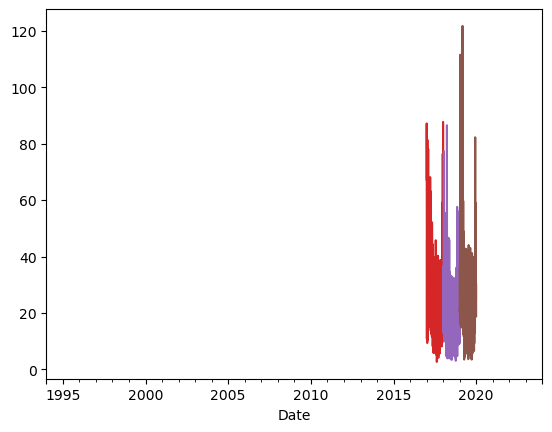

In [13]:
seoul_df.groupby(seoul_df.index.year)['PM2.5'].plot()

Date
2010    Axes(0.125,0.11;0.775x0.77)
2011    Axes(0.125,0.11;0.775x0.77)
2012    Axes(0.125,0.11;0.775x0.77)
2013    Axes(0.125,0.11;0.775x0.77)
2014    Axes(0.125,0.11;0.775x0.77)
2015    Axes(0.125,0.11;0.775x0.77)
Name: PM2.5, dtype: object

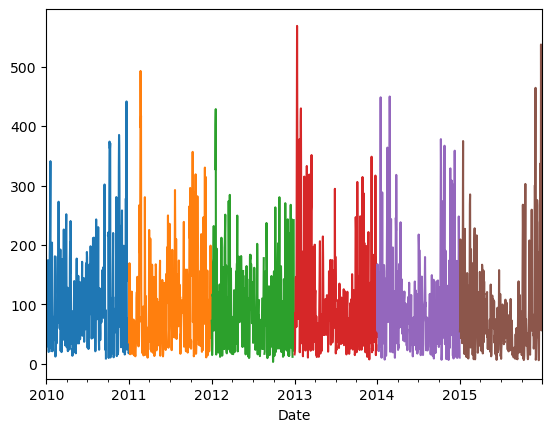

In [14]:
beijing_df.groupby(beijing_df.index.year)['PM2.5'].plot()